# Fitting a birth-death process to existing trees

We minimize spectral distances between an ensemble of trees generated by a 
birth-death simulation trees and a target tree. From this, we get some
"reasonable" parameters to use for generating trees with similar statistics.

In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from dendropy import simulate, Tree
from dendropy.calculate.treecompare import weighted_robinson_foulds_distance
from dendropy.calculate.treecompare import unweighted_robinson_foulds_distance
from dendropy.calculate.treecompare import euclidean_distance, mason_gamer_kellogg_score, symmetric_difference
from numpy import linspace
from pyprind import ProgBar
import seaborn
import pandas

In [3]:
host_tree = Tree.get_from_path( '../fishpoo/host_tree/mcgeetree/mcgee_trimmed.tree', schema='newick')

The tree distance methods in `dendropy`, like the Robinson-Fould distance, 

In [4]:
from scipy.stats import skew, entropy, gaussian_kde, kurtosis, pearsonr

# tree spectral analysis, all in one cell!

def adjacency( t ) :
    nodelist = list( t.nodes() )
    aj = zeros( ( len(nodelist), len(nodelist) ) )
    for node in t.nodes() :
        i = nodelist.index( node )
        for child in node.child_node_iter() :
            j = nodelist.index( child )
            aj[i,j] = child.edge_length
            aj[j,i] = child.edge_length
    return aj

def laplacian( t ) :
    aj = adjacency( t )
    lp = zeros( aj.shape )
    for i,row in enumerate( aj ) :
        lp[i,i] = sum(row)
    return lp - aj

def lp_spectrum( t ) :
    return gaussian_kde( numpy.linalg.eigvalsh( laplacian(t) ), 
                         bw_method=0.4 ).pdf( linspace( -0.5,1.5,200 ) )
    
def spectral_distance( t1, t2 ) :
    t1_s = lp_spectrum( t1 )
    t2_s = lp_spectrum( t2 )
    return 0.5 * ( entropy( t1_s, t2_s ) + entropy( t2_s, t1_s ) )

In [5]:
kurtosis( lp_spectrum(host_tree) )

5.179234583851999

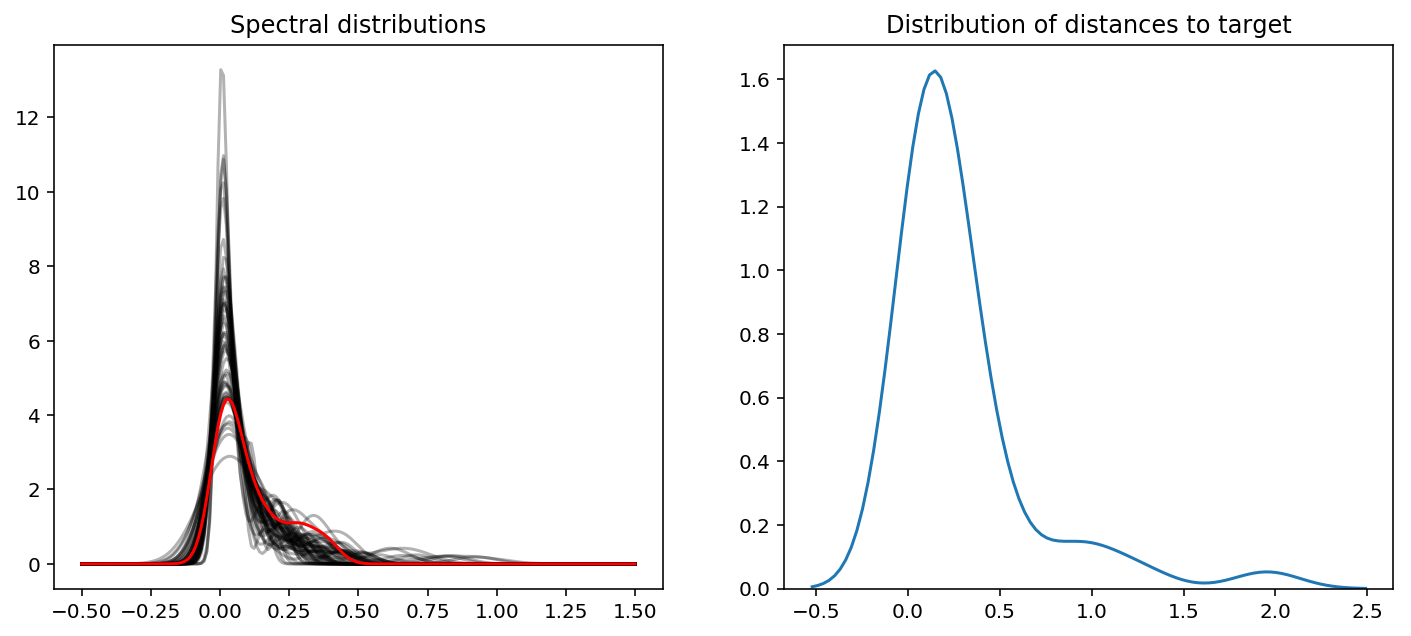

In [25]:
figure( figsize=(12,5) )

K = 50

subplot(1,2,1)
d = []
X = linspace( -0.5,1.5,200 )
for k in range(K) :
    sim = simulate.birth_death_tree( 12.0, 2.0,
                                     taxon_namespace=host_tree.taxon_namespace,
                                     num_extant_tips=len(host_tree.leaf_nodes()) )
    plot( X, lp_spectrum( sim ), color='black', alpha=0.3 )
    d.append( spectral_distance( sim, host_tree ))
plot( X, lp_spectrum( host_tree ), color='red' )
title( 'Spectral distributions' )


subplot(1,2,2)
title( 'Distribution of distances to target' )
seaborn.kdeplot( array(d)[numpy.isfinite(d)] )

In [7]:
N,M,K = 100, 100, 10

min_birth = 2.0
max_birth = 20.0

min_death = 0.5
max_death = 6.0

p = ProgBar( N*M*K, 'simulating trees...', monitor=True )
discordance = zeros( (N,M) )
fuzziness   = zeros( (N,M) )
for n,i in enumerate( linspace( min_birth, max_birth, N ) ) :
    for m,j in enumerate( linspace( min_death, max_death, M ) ):
        #if i>j : continue
        d = []
        for k in range( K ) :
            p.update()
            sim = simulate.birth_death_tree(i, j,
                                            taxon_namespace=host_tree.taxon_namespace,
                                            num_extant_tips=len(host_tree.leaf_nodes()),
                                            max_time=0.5)
            if sim.max_distance_from_root() < 0.01 : continue
            d.append( spectral_distance( host_tree, sim ) )
            #d.append( euclidean_distance(host_tree,sim) )
            #d.append( unweighted_robinson_foulds_distance( host_tree, sim ) )
            #d.append( symmetric_difference( host_tree, sim ) )
            #d.append( weighted_robinson_foulds_distance( host_tree, sim ) )
        discordance[n,m] = mean(array(d)[numpy.isfinite(d)])
        fuzziness[n,m]   = std(array(d)[numpy.isfinite(d)])

/home/russell/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/russell/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/russell/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/russell/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/russell/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:06:08


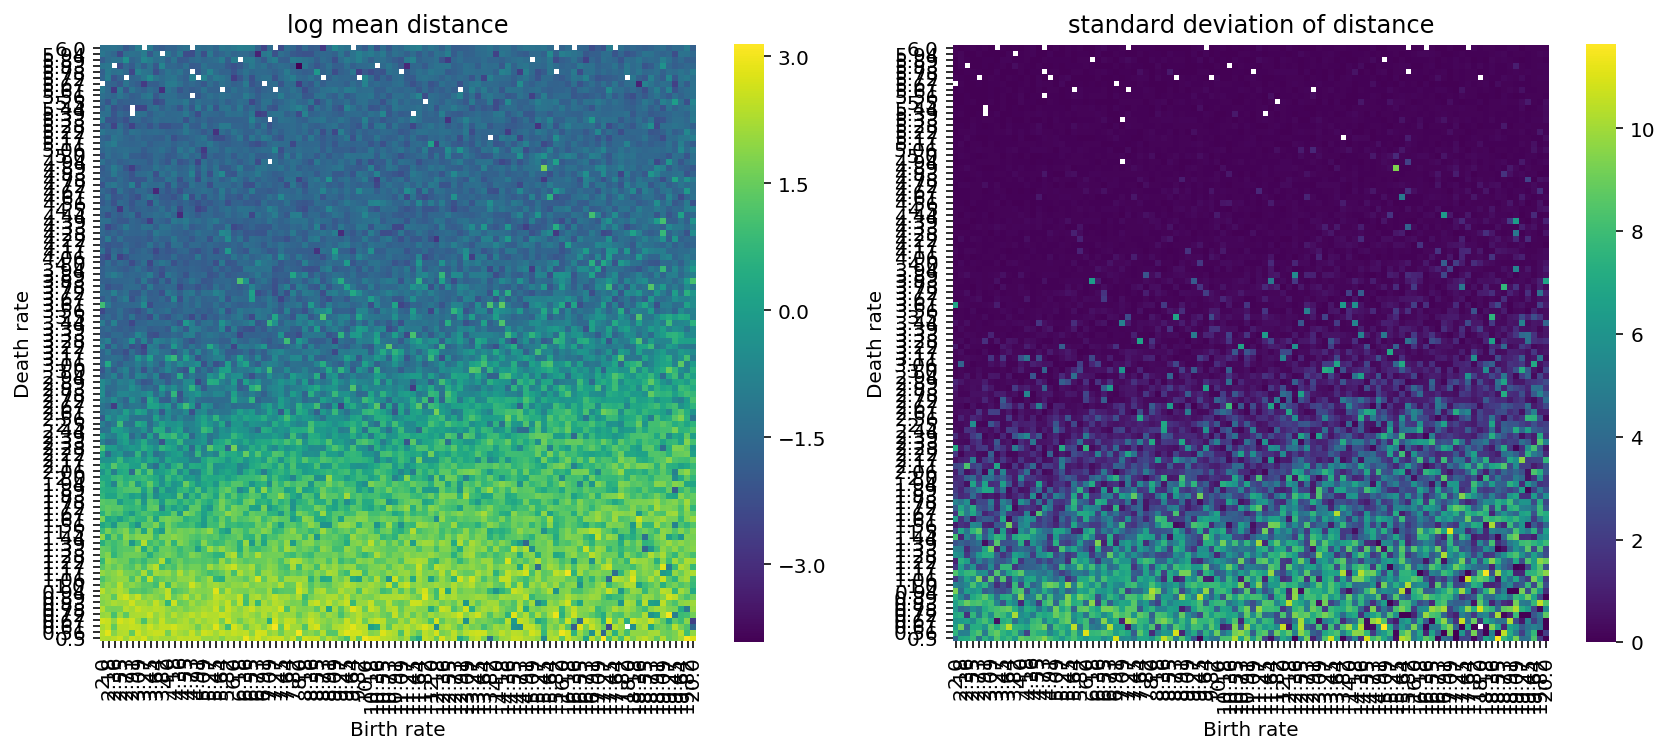

In [8]:
figure( figsize=(12,5) )

X = linspace( min_birth, max_birth, N ).round(2)
Y = linspace( min_death, max_death, M ).round(2)

subplot(1,2,1)
title('log mean distance')
ax1 = seaborn.heatmap( log(discordance),
                       xticklabels=X,
                       yticklabels=Y,
                       square=True, cmap='viridis' )
xlabel('Birth rate')
ylabel('Death rate')
ax1.invert_yaxis()

subplot(1,2,2)
title('standard deviation of distance')
ax2 = seaborn.heatmap( fuzziness,
                       xticklabels=X,
                       yticklabels=Y,
                       square=True, cmap='viridis' )
xlabel('Birth rate')
ylabel('Death rate')
ax2.invert_yaxis()

tight_layout()
savefig( 'birth_death.png' )

In [438]:
from scipy.optimize import fmin, basinhopping, minimize, minimize_scalar

K = 100
trajectory = []
def minf(x):
    if x[0] <= 0 or x[1] <= 0 : return numpy.infty
    if x[0] < x[1] : return numpy.infty
    d = []
    for k in range( K ) :
        d = []
        sim = simulate.birth_death_tree(x[0], x[1],
                                        taxon_namespace=host_tree.taxon_namespace,
                                        num_extant_tips=len(host_tree.leaf_nodes()) )
        #d.append( euclidean_distance(host_tree,sim) )
        d.append( spectral_distance( host_tree, sim ) )
    m_d = mean( array(d)[numpy.isfinite(d)] )
    #print x[0], x[1], m_d
    trajectory.append( (x[0],x[1],m_d) )
    return m_d

#print minimize( minf, [5.0,2.0], method='Powell' )
print basinhopping( minf, [5.0,2.0], stepsize=0.1, T=1.0, niter=100 )

                        fun: 0.01499808716181925
 lowest_optimization_result:       fun: 0.01499808716181925
 hess_inv: array([[8.89671000e-17, 1.04352364e-16],
       [1.04352364e-16, 1.22421439e-16]])
      jac: array([64363718.37650734, 29318303.09731406])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 120
      nit: 3
     njev: 27
   status: 2
  success: False
        x: array([5.06799382, 2.02054937])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 101
                       nfev: 11563
                        nit: 100
                       njev: 2578
                          x: array([5.06799382, 2.02054937])


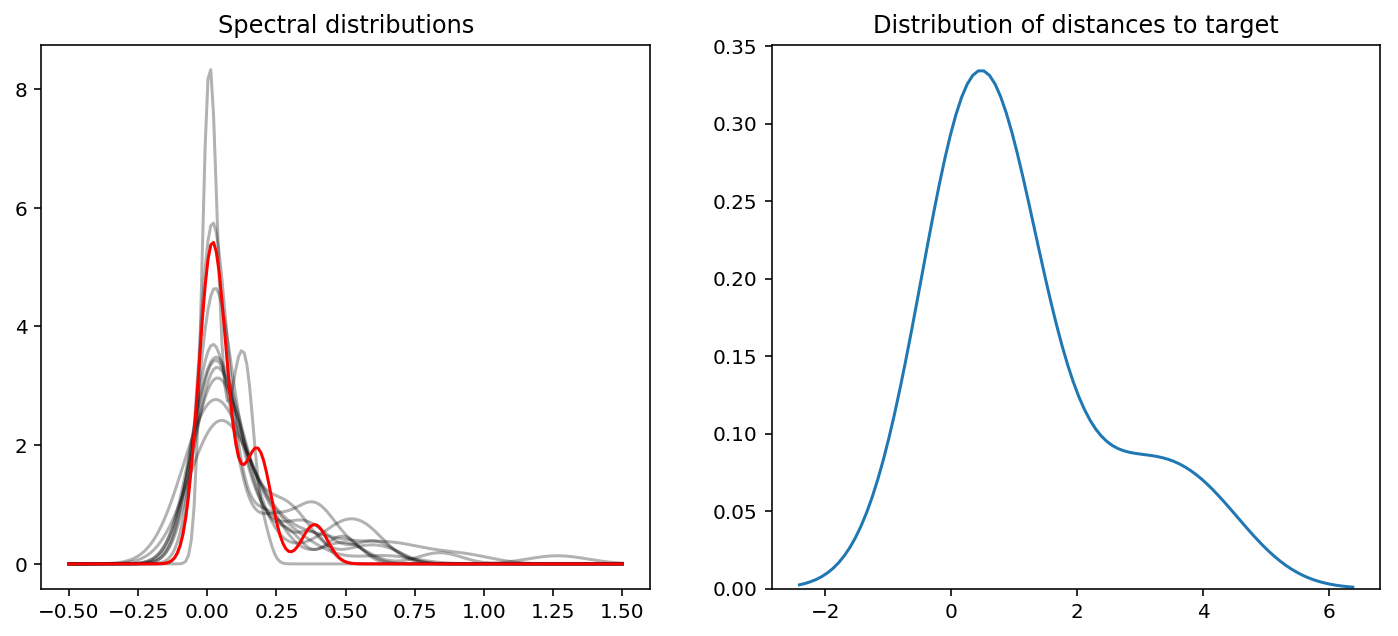

In [58]:
test_tree = Tree.get_from_path( 'test_host.relaxed.tree', schema='newick')

figure( figsize=(12,5) )

K = 10

subplot(1,2,1)
d = []
X = linspace( -0.5,1.5,200 )
for k in range(K) :
    sim = simulate.birth_death_tree( 8.0, 2.0,
                                     taxon_namespace=host_tree.taxon_namespace,
                                     num_extant_tips=len(host_tree.leaf_nodes()) )
    plot( X, lp_spectrum( sim ), color='black', alpha=0.3 )
    d.append( spectral_distance( sim, test_tree ))
plot( X, lp_spectrum( test_tree ), color='red' )
title( 'Spectral distributions' )

subplot(1,2,2)
title( 'Distribution of distances to target' )
seaborn.kdeplot( array(d)[numpy.isfinite(d)] )

In [435]:
tj = pandas.DataFrame( trajectory, columns=['birth','death','distance'] )
tj.head()

,birth,death,distance
0,5.000000,2.000000,4.851999
1,5.000000,2.000000,5.507176
2,5.000000,2.000000,4.797873
3,5.000000,2.000000,1.076898
4,3.993429,2.083155,9.206243


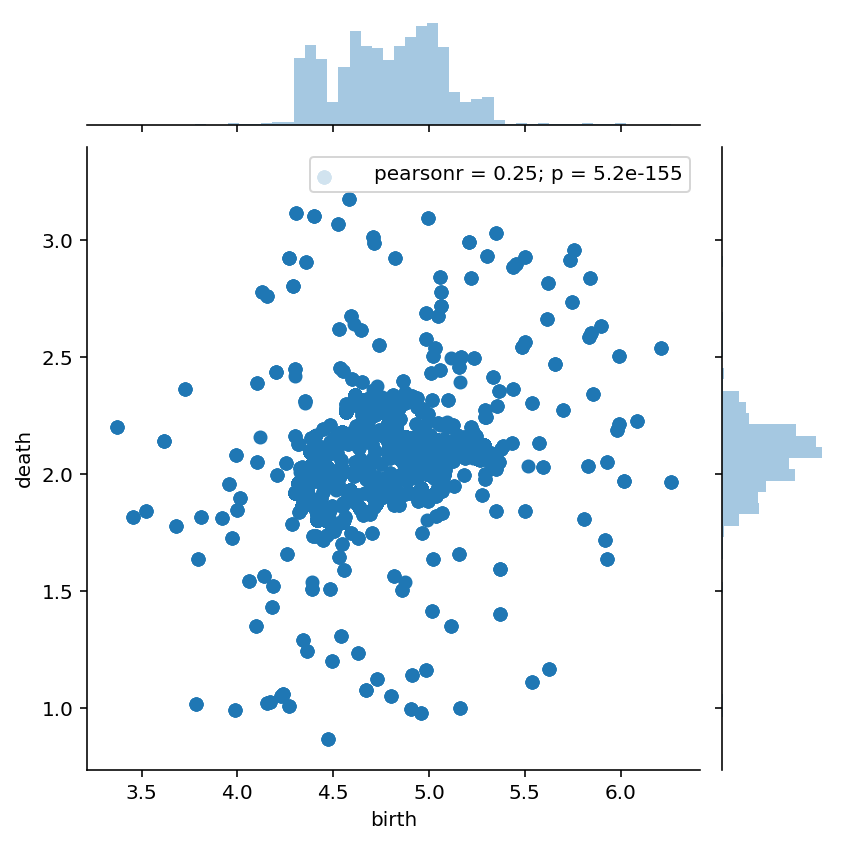

In [439]:
seaborn.jointplot( x='birth', y='death', data=tj )

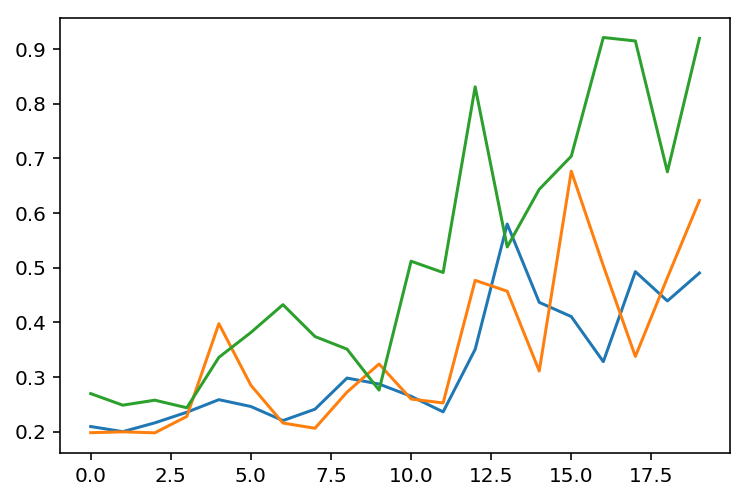

In [445]:
plot(discordance[10])
plot(discordance[9])
plot(discordance[8])

In [39]:
from os import listdir

guest_names = []
guest_trees = []
guest_spectra = []
for filename in listdir( 'various_trees/' ) :
    guest_names.append(filename)
    guest_tree = Tree.get_from_path( 'various_trees/' + filename, schema='newick')
    guest_trees.append( guest_tree )
    guest_spectra.append( lp_spectrum( guest_tree ) )

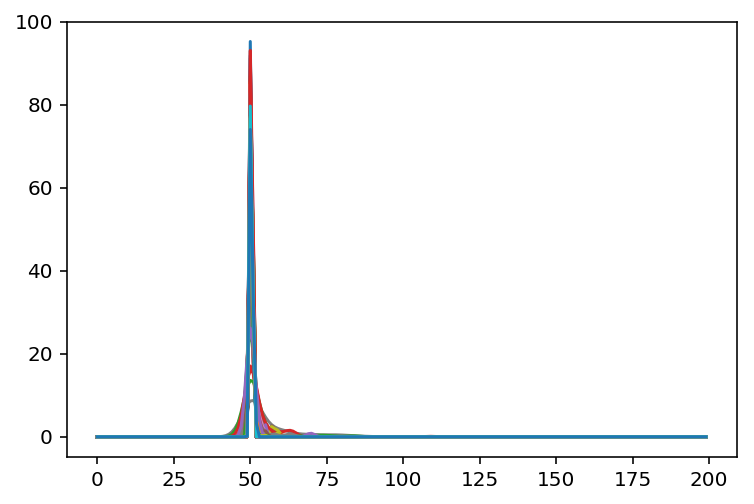

In [8]:
for spectrum in guest_spectra :
    plot(spectrum)

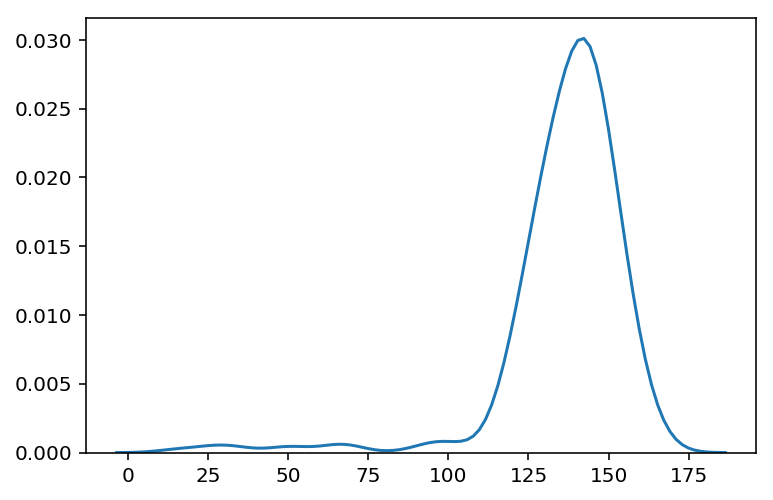

In [9]:
seaborn.kdeplot( [ kurtosis(s) for s in guest_spectra ] )

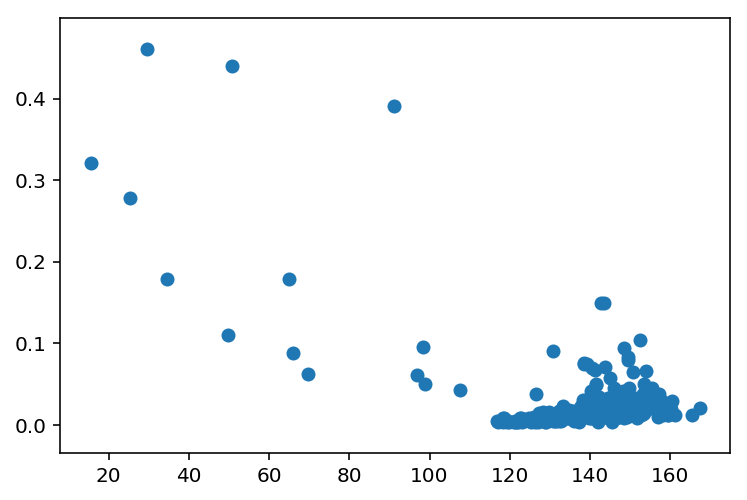

In [46]:
guest_k = []
guest_d = []
for n,s in enumerate(guest_spectra) :
    guest_k.append( kurtosis(s) )
    guest_d.append( guest_trees[n].max_distance_from_root() )
scatter( guest_k, guest_d )

In [32]:
from scipy.optimize import fmin, basinhopping, minimize, minimize_scalar

K = 10

guest_tree = guest_trees[27]

trajectory = []
def minf(x):
    if x[0] <= 0 or x[1] <= 0 : return numpy.infty
    if x[0] < x[1] : return numpy.infty
    d = []
    for k in range( K ) :
        d = []
        sim = simulate.birth_death_tree(x[0], x[1],
                                        taxon_namespace=host_tree.taxon_namespace,
                                        num_extant_tips=len(host_tree.leaf_nodes()) )
        #d.append( euclidean_distance(host_tree,sim) )
        d.append( spectral_distance( guest_tree, sim ) )
    m_d = mean( array(d)[numpy.isfinite(d)] )
    #print x[0], x[1], m_d
    trajectory.append( (x[0],x[1],m_d) )
    return m_d

print( minimize( minf, [5,3] ) )

      fun: 1.6052971386573107
 hess_inv: array([[ 2.87980212e-11, -9.91612249e-12],
       [-9.91526227e-12,  3.41415835e-12]])
      jac: array([2.00060427e+08, 3.02198964e+08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 103
      nit: 2
     njev: 23
   status: 2
  success: False
        x: array([4.99997377, 2.99996183])
